## extractive models test on student lease (manually annoated data -> 500+ questions 50+ hours of work )
## total lines of code: 929

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from pathlib import Path

# In Google Colab, if your notebook is in /content and the files are as above:
BASE_DIR = Path("/content/drive/My Drive/Dissertation/phase_2")
AGREEMENTS_DIR = BASE_DIR / "agreements"
GOLD_STANDARD_JSON = BASE_DIR / "gold_standard.json"
PROCESSED_DIR = BASE_DIR / "processed"         # output for processed main PDFs
IMAGES_DIR = BASE_DIR / "images"



print("Base Directory:", BASE_DIR)
print("Agreements Directory:", AGREEMENTS_DIR)
print("Gold Standard JSON:", GOLD_STANDARD_JSON)


Base Directory: /content/drive/My Drive/Dissertation/phase_2
Agreements Directory: /content/drive/My Drive/Dissertation/phase_2/agreements
Gold Standard JSON: /content/drive/My Drive/Dissertation/phase_2/gold_standard.json


In [35]:
pip install pymupdf4llm pdfplumber transformers rank_bm25 whoosh faiss-cpu evaluate bert-score tqdm rouge_score

# IMPORTS & CONFIGURATION & PATHS

In [36]:

##############################
# Imports
##############################
import os
import time  # ensure time is imported
import re
import json
import string
from pathlib import Path
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use your PDF-to-markdown converter; here we use pymupdf4llm as in your snippet.
import pymupdf4llm

# For alternative PDF extraction (if needed)
import pdfplumber

# For robust token counting, we use a Hugging Face tokenizer.
from transformers import AutoTokenizer, pipeline

# For TF-IDF retrieval:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# For BM25 retrieval:
from rank_bm25 import BM25Okapi

# For Woosh

from whoosh.index import create_in
from whoosh.fields import Schema, TEXT, ID
from whoosh.qparser import QueryParser
import tempfile
import shutil

# For FIASS

import faiss
from sentence_transformers import SentenceTransformer


# For metrics:
import numpy as np
import evaluate
from bert_score import score as bertscore_score
import torch



##############################
# CONFIGURATION
##############################

# Maximum token limit for each chunk (set below 512 to allow room for question tokens and special tokens)
MAX_CHUNK_TOKENS = 400

# Choose a tokenizer for counting tokens (using a BERT tokenizer as an example)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# PDF PREPROCESSING & MARKDOWN EXTRACTION

In [37]:
def pdf_to_markdown(pdf_path: Path) -> str:

    """
    Convert a PDF to markdown using pymupdf4llm.
    If there are issues with pymupdf4llm, consider switching to pdfplumber.
    """

    return pymupdf4llm.to_markdown(str(pdf_path))

def clean_text(text: str) -> str:

    """
    Remove unwanted artifacts and non-ASCII characters.
    """

    text = re.sub(r'â', '', text)
    text = re.sub(r'\*+', '', text)
    text = re.sub(r'â*', '', text)
    text = text.encode("ascii", errors="ignore").decode("ascii")

    return text.strip()

def split_markdown_by_headers(markdown: str) -> List[Dict[str, str]]:

    """
    Splits markdown text into sections based on headers.
    Returns a list of dicts with keys 'title' and 'content'.
    """

    sections = []
    current_section = {"title": None, "content": ""}

    for line in markdown.splitlines():

        header_match = re.match(r'^(#{1,6})\s+(.*)', line)
        if header_match:
            if current_section["title"] is not None or current_section["content"].strip():
                sections.append(current_section)
            title = header_match.group(2).strip()
            current_section = {"title": title, "content": ""}
        else:
            current_section["content"] += line + "\n"

    if current_section["title"] is not None or current_section["content"].strip():
        sections.append(current_section)

    return sections

def process_content(text: str) -> str:

    """
    Replace newline characters with a space and collapse extra spaces.
    """

    text = text.replace("\n", " ")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def preprocess_markdown_file(file_path: Path) -> List[Dict[str, str]]:

    """
    Process a markdown file: clean, split by headers, process content,
    and filter out trivial sections.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        markdown = f.read()
    markdown = clean_text(markdown)
    sections = split_markdown_by_headers(markdown)

    for sec in sections:
        sec["content"] = process_content(sec["content"])

    # Filter out sections that are too trivial
    filtered_sections = []

    for sec in sections:

        if not sec["content"].strip():
            continue
        filtered_sections.append(sec)

    return filtered_sections

def save_to_json(data, filename: Path):

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"Data saved to {filename}")

def process_all_agreement_pdfs():

    """
    Loop over all main agreement PDFs (skip Q&A PDFs that contain '_QA' in the filename)
    and produce a JSON file per agreement.
    """

    for pdf_file in AGREEMENTS_DIR.glob("Agreement_*.pdf"):

        if "_QA" in pdf_file.stem:
            continue  # Skip Q&A PDFs
        print(f"Processing {pdf_file.name} ...")

        # Convert PDF to markdown text.
        md_text = pdf_to_markdown(pdf_file)

        # Save the markdown to the output directory using the correct path.
        output_md_path = AGREEMENTS_DIR / f"{pdf_file.stem}.md"
        output_md_path.write_text(md_text, encoding="utf-8")
        print(f"Saved markdown to {output_md_path}")

        sections = preprocess_markdown_file(pdf_file.with_suffix(".md"))
        # In case you haven't already saved markdown to disk, you can also do:
        # sections = split_markdown_by_headers(clean_text(md_text))
        # Save processed sections to JSON:
        output_json = PROCESSED_DIR / f"{pdf_file.stem}.json"
        save_to_json(sections, output_json)


##############################
# FURTHER CHUNKING USING TOKEN COUNTS
##############################

def chunk_section_by_tokens(section: Dict[str, str], max_tokens: int = MAX_CHUNK_TOKENS) -> List[Dict[str, str]]:

    """
    Use the Hugging Face tokenizer to count tokens and split a section's content into sub‐chunks.
    The method splits on sentence boundaries if possible.
    """

    text = section["content"]

    # Tokenize using the model's tokenizer (which returns token IDs)
    tokens = tokenizer.tokenize(text)

    if len(tokens) <= max_tokens:
        return [section]

    # For a better split, we can try to split by sentences.
    # Here we use a naive regex sentence split; you might also use nltk.sent_tokenize.
    sentences = re.split(r'(?<=[.!?])\s+', text)
    chunks = []
    current_chunk = ""
    current_tokens = []

    for sent in sentences:
        sent_tokens = tokenizer.tokenize(sent)

        # If adding the sentence exceeds max_tokens, store the current chunk.
        if len(current_tokens) + len(sent_tokens) > max_tokens:
            if current_chunk:
                chunks.append({
                    "title": section["title"],
                    "content": current_chunk.strip()
                })
            # Start a new chunk with this sentence.
            current_chunk = sent + " "
            current_tokens = sent_tokens
        else:
            current_chunk += sent + " "
            current_tokens += sent_tokens

    if current_chunk:
        chunks.append({
            "title": section["title"],
            "content": current_chunk.strip()
        })

    return chunks

def further_chunk_sections(sections: List[Dict[str, str]], max_tokens: int = MAX_CHUNK_TOKENS) -> List[Dict[str, str]]:

    """
    Apply token-based chunking to all sections.
    """

    final_chunks = []

    for sec in sections:
        sub_chunks = chunk_section_by_tokens(sec, max_tokens=max_tokens)
        final_chunks.extend(sub_chunks)

    return final_chunks


# GOLD STANDARD Q&A EXTRACTION

In [38]:
def save_to_json_QA(data, filename):

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Gold standard JSON saved to {filename}")



def extract_text_from_pdf(pdf_path):

    """Extract text from a PDF file using pdfplumber."""

    text = ""

    with pdfplumber.open(pdf_path) as pdf:

        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"

    return text

def extract_qa_pairs(text):

    """
    Extract Q&A pairs from text.
    Assumes a format where each pair starts with 'Question <number>:'
    and then 'Answer :' with the answer continuing until the next question or end-of-text.
    """

    qa_pattern = re.compile(
        r"Question\s*(\d+)\s*:\s*(.*?)\s*Answer\s*:\s*(.*?)(?=Question\s*\d+\s*:|$)",
        re.DOTALL | re.IGNORECASE
    )

    qa_pairs = []

    for match in qa_pattern.finditer(text):

        question_num, question, answer = match.groups()
        qa_pairs.append({
            "question_number": question_num.strip(),
            "question": question.strip(),
            "answer": answer.strip()
        })

    return qa_pairs


def build_gold_standard():

    """
    Loop over all Q&A PDFs and build a dictionary.
    Save as a single JSON file.
    """

    # Built a dictionary to hold the gold standard for all agreements
    gold_standard = {}

    # Looping over all Q&A PDFs in the agreements directory

    for pdf_file in AGREEMENTS_DIR.glob("*_QA.pdf"):

        # Extracting an agreement identifier from the filename, "Agreement_N"
        agreement_id = pdf_file.stem.split("_QA")[0]
        print(f"Processing Q&A for {agreement_id} from {pdf_file.name}")

        # Extract text and then Q&A pairs using pdfplumber
        text = extract_text_from_pdf(pdf_file)
        qa_pairs = extract_qa_pairs(text)

        # Store the result in the gold standard dictionary
        gold_standard[agreement_id] = qa_pairs

    # Order the dictionary by the numeric part of the agreement id.
    # Assuming agreement IDs are in the form "Agreement_<number>"
    ordered_gold_standard = dict(

        sorted(
            gold_standard.items(),
            key=lambda x: int(x[0].split('_')[1]) if x[0].split('_')[1].isdigit() else 0
        )

    )

    save_to_json(ordered_gold_standard, GOLD_STANDARD_JSON)



# RETRIEVAL FUNCTIONS (TF-IDF & BM25 & WHOOSH & FIASS)

In [39]:
class WhooshRetriever:
    def __init__(self):
        # Create a temporary directory for the Whoosh index
        self.index_dir = tempfile.mkdtemp()
        # Define the schema: an ID and the chunk content.
        schema = Schema(doc_id=ID(stored=True), content=TEXT(stored=True))
        self.ix = create_in(self.index_dir, schema)

    def index(self, chunks: List[Dict[str, str]]):
        writer = self.ix.writer()
        for i, chunk in enumerate(chunks):
            writer.add_document(doc_id=str(i), content=chunk["content"])
        writer.commit()

    def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
        results = []
        with self.ix.searcher() as searcher:
            parser = QueryParser("content", schema=self.ix.schema)
            parsed_query = parser.parse(query)
            hits = searcher.search(parsed_query, limit=top_k)
            for hit in hits:
                results.append({"text": hit["content"], "score": hit.score})
        return results

    def cleanup(self):
        # Delete the temporary index directory
        shutil.rmtree(self.index_dir)



class FaissRetriever:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name)
        self.index = None
        self.doc_embeddings = None
        self.chunk_texts = None

    def build_index(self, chunks: List[Dict[str, str]]):
        self.chunk_texts = [chunk["content"] for chunk in chunks]
        self.doc_embeddings = self.embedder.encode(self.chunk_texts, convert_to_numpy=True)
        dimension = self.doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        faiss.normalize_L2(self.doc_embeddings)
        self.index.add(self.doc_embeddings)

    def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
        q_embed = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(q_embed)
        distances, indices = self.index.search(q_embed, top_k)
        results = []
        for dist, idx in zip(distances[0], indices[0]):
            results.append({
                "text": self.chunk_texts[idx],
                "score": float(dist)
            })
        return results


def tfidf_search(chunks: List[Dict[str, str]], query: str, top_k: int = 3) -> List[Dict[str, any]]:
    docs = [c["content"] for c in chunks]
    vectorizer = TfidfVectorizer()
    doc_vectors = vectorizer.fit_transform(docs)
    query_vec = vectorizer.transform([query])
    scores = cosine_similarity(query_vec, doc_vectors)[0]
    ranked_idx = np.argsort(scores)[::-1]
    results = []
    for idx in ranked_idx[:top_k]:
        results.append({"text": docs[idx], "score": float(scores[idx])})
    return results

def bm25_search(chunks: List[Dict[str, str]], query: str, top_k: int = 3) -> List[Dict[str, any]]:
    docs = [c["content"] for c in chunks]
    tokenized_docs = [tokenizer.tokenize(doc) for doc in docs]
    bm25 = BM25Okapi(tokenized_docs)
    query_tokens = tokenizer.tokenize(query)
    scores = bm25.get_scores(query_tokens)
    ranked_idx = np.argsort(scores)[::-1]
    results = []
    for idx in ranked_idx[:top_k]:
        results.append({"text": docs[idx], "score": float(scores[idx])})
    return results


# use WOOSH and FIASS too

# QA MODELS LOADING

In [40]:

def load_qa_pipelines():

    return {
        "jasu_legalbert": pipeline(
            "question-answering",
            model="Jasu/bert-finetuned-squad-legalbert",
            tokenizer="Jasu/bert-finetuned-squad-legalbert"
        ),

        "nlpaueb_legalbert": pipeline(
            "question-answering",
            model="nlpaueb/legal-bert-base-uncased",
            tokenizer="nlpaueb/legal-bert-base-uncased"
        ),

        "atharvamundada_bertlarge_legal": pipeline(
            "question-answering",
            model="atharvamundada99/bert-large-question-answering-finetuned-legal",
            tokenizer="atharvamundada99/bert-large-question-answering-finetuned-legal"
        )
    }

# RUNNING THE RETRIEVAL & QA EXPERIMENT & EVALUATION METRICS

In [41]:
def run_experiments(gold_data,
                    processed_docs,
                    qa_models,
                    retrievers,
                    top_k = 3):

    """
    For each agreement (from the gold standard), retrieve top chunks using TF-IDF and BM25,
    run each QA model on the retrieved chunks for each question,
    and store the best predicted answer.
    """

    results = []

    for agreement_id, qa_pairs in tqdm(gold_data.items(), desc="Processing Agreements"):

        if agreement_id not in processed_docs:
            print(f"Warning: No processed chunks for {agreement_id}")
            continue

        chunks = processed_docs[agreement_id]


        if not chunks or all(not re.search(r'\w', chunk.get("content", "")) for chunk in chunks):
            print(f"Skipping {agreement_id} due to empty or non-informative content.")
            continue


        # For better retrieval, we further chunk each section using our improved method.
        chunks = further_chunk_sections(chunks, max_tokens=MAX_CHUNK_TOKENS)


        # For each retriever, we re-index the chunks
        for retriever_name, retriever in retrievers.items():

          # For Faiss, use build_index(); for others, use index()
          if retriever_name == "faiss":
              retriever.build_index(chunks)
          else:
              retriever.index(chunks)

          # For each Q&A pair in the agreement
          for qa in tqdm(qa_pairs, desc=f"QA pairs for {agreement_id} ({retriever_name})", leave=False):
              question = qa["question"]
              gold_answer = qa["answer"]
              # Retrieve chunks once per QA pair
              retrieved = retriever.search(query=question, top_k=top_k)

              # For each QA model, measure model-specific timing.
              for model_name, qa_pipeline in qa_models.items():
                  model_start_time = time.time()  # Start timer for this model
                  best_answer = ""
                  best_score = -1.0

                  for item in retrieved:
                      try:
                          pred = qa_pipeline({
                              "question": question,
                              "context": item["text"]
                          })
                          if pred["score"] > best_score:
                              best_score = pred["score"]
                              best_answer = pred["answer"]
                      except Exception as e:
                          print(f"QA error ({retriever_name}, {model_name}): {e}")

                  elapsed_time = time.time() - model_start_time  # Model-specific elapsed time

                  results.append({
                      "retriever": retriever_name,
                      "Model": model_name,  # Ensure consistency: using "Model" (capitalized)
                      "agreement_id": agreement_id,
                      "question": question,
                      "gold_answer": gold_answer,
                      "pred_answer": best_answer,
                      "confidence": best_score,
                      "time": elapsed_time
                  })


    return results


##############################
#EVALUATION METRICS
##############################

def normalize_text(s):

    s = s.lower().strip()
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r'\s+', ' ', s)
    return s


def tokenize_text(s):

    return normalize_text(s).split()


def compute_exact_match(pred, gold):

    return 1.0 if normalize_text(pred) == normalize_text(gold) else 0.0



def compute_token_level_f1(pred, gold):

    pred_tokens = tokenize_text(pred)
    gold_tokens = tokenize_text(gold)
    common = 0
    gold_counts = {}

    for w in gold_tokens:
        gold_counts[w] = gold_counts.get(w, 0) + 1

    pred_counts = {}

    for w in pred_tokens:
        pred_counts[w] = pred_counts.get(w, 0) + 1

    for w in gold_counts:
        if w in pred_counts:
            common += min(gold_counts[w], pred_counts[w])

    if len(pred_tokens) == 0 and len(gold_tokens) == 0:
        return 1.0

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    precision = common / len(pred_tokens)
    recall = common / len(gold_tokens)
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

def compute_partial_f1(pred: str, gold: str) -> float:

    pred_tokens = set(tokenize_text(pred))
    gold_tokens = tokenize_text(gold)

    if not gold_tokens:
        return 1.0 if not pred_tokens else 0.0

    matches = sum(1 for w in gold_tokens if w in pred_tokens)
    return matches / len(gold_tokens)


def evaluate_all(results: List[Dict[str, str]]) -> Dict:

    from collections import defaultdict
    rouge = evaluate.load("rouge")
    grouped = defaultdict(lambda: {"preds": [], "golds": [], "times": [], "confs": []})

    # Initialize the embedder for semantic similarity.
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

    def compute_semantic_similarity(pred, gold):
        pred_emb = embedder.encode([pred])
        gold_emb = embedder.encode([gold])
        return float(cosine_similarity(pred_emb, gold_emb)[0][0])



    for res in results:
        key = (res["retriever"], res["Model"])
        grouped[key]["preds"].append(res["pred_answer"])
        grouped[key]["golds"].append(res["gold_answer"])
        grouped[key]["times"].append(res.get("time", 0))
        grouped[key]["confs"].append(res.get("confidence", 0))
    final = {}

    for key, data in grouped.items():

        ems = [compute_exact_match(p, g) for p, g in zip(data["preds"], data["golds"])]
        f1s = [compute_token_level_f1(p, g) for p, g in zip(data["preds"], data["golds"])]
        pf1s = [compute_partial_f1(p, g) for p, g in zip(data["preds"], data["golds"])]
        avg_em = np.mean(ems)
        avg_f1 = np.mean(f1s)
        avg_pf1 = np.mean(pf1s)
        rouge_scores = rouge.compute(predictions=data["preds"], references=data["golds"])
        avg_rouge_l = rouge_scores["rougeL"]
        P, R, F = bertscore_score(data["preds"], data["golds"], lang="en")
        avg_bertscore = float(torch.mean(F))

        # Compute semantic similarity for each pair and average them.
        semantic_sims = [compute_semantic_similarity(p, g) for p, g in zip(data["preds"], data["golds"])]
        avg_semantic_sim = np.mean(semantic_sims)
        avg_time = np.mean(data["times"])
        avg_conf = np.mean(data["confs"])

        final[key] = {
            "Exact Match": avg_em,
            "F1": avg_f1,
            "Partial F1": avg_pf1,
            "ROUGE-L": avg_rouge_l,
            "BERTScore": avg_bertscore,
            "Semantic Similarity": avg_semantic_sim,
            "Avg Time": avg_time,
            "Avg Confidence": avg_conf,

        }

    return final

# MAIN EXECUTION

Processing Agreement_18.pdf ...
Processing /content/drive/My Drive/Dissertation/phase_2/agreements/Agreement_18.pdf...
[                                        ] (0/75)[                                        ] ( 1/75)=[=                                       ] ( 2/75)[=                                       ] ( 3/75)=[==                                      ] ( 4/75)[==                                      ] ( 5/75)=

Device set to use cuda:0
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Device set to use cuda:0
Processing Agreements:   0%|          | 0/18 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors

QA pairs for Agreement_1 (tfidf): 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]
                                                                                 
QA pairs for Agreement_1 (bm25): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]
                                                                                
QA pairs for Agreement_1 (whoosh):  13%|█▎        | 2

Skipping Agreement_12 due to empty or non-informative content.



QA pairs for Agreement_13 (tfidf): 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]
                                                                                  
QA pairs for Agreement_13 (bm25): 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]
                                                                                 
QA pairs for Agreement_13 (whoosh):  70%|███████   | 21/30 [00:00<00:00, 208.25it/s]
                                                                                    
QA pairs for Agreement_14 (tfidf): 100%|██████████| 30/30 [00:19<00:00,  1.33it/s]
                                                                                  
QA pairs for Agreement_14 (bm25): 100%|██████████| 30/30 [00:23<00:00,  1.23it/s]
                                                                                 
QA pairs for Agreement_14 (whoosh):  70%|███████   | 21/30 [00:00<00:00, 202.39it/s]
                                                                                    

Result keys: dict_keys(['retriever', 'Model', 'agreement_id', 'question', 'gold_answer', 'pred_answer', 'confidence', 'time'])
Detailed results saved to /content/drive/My Drive/Dissertation/phase_2/detailed_results.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Aggregated metrics saved to /content/drive/My Drive/Dissertation/phase_2/aggregated_metrics.csv
Retriever               object
Model                   object
Exact Match            float64
F1                     float64
Partial F1             float64
ROUGE-L                float64
BERTScore              float64
Semantic Similarity    float64
Avg Time               float64
Avg Confidence         float64
dtype: object
  Retriever                           Model  Exact Match        F1  \
0     tfidf                  jasu_legalbert     0.012500  0.166971   
1     tfidf               nlpaueb_legalbert     0.000000  0.093691   
2     tfidf  atharvamundada_bertlarge_legal     0.020833  0.201003   
3      bm25                  jasu_legalbert     0.012500  0.171824   
4      bm25               nlpaueb_legalbert     0.000000  0.080443   

   Partial F1   ROUGE-L  BERTScore  Semantic Similarity  Avg Time  \
0    0.172296  0.167431   0.832777             0.396309  0.089981   
1    0.108810  0.0836

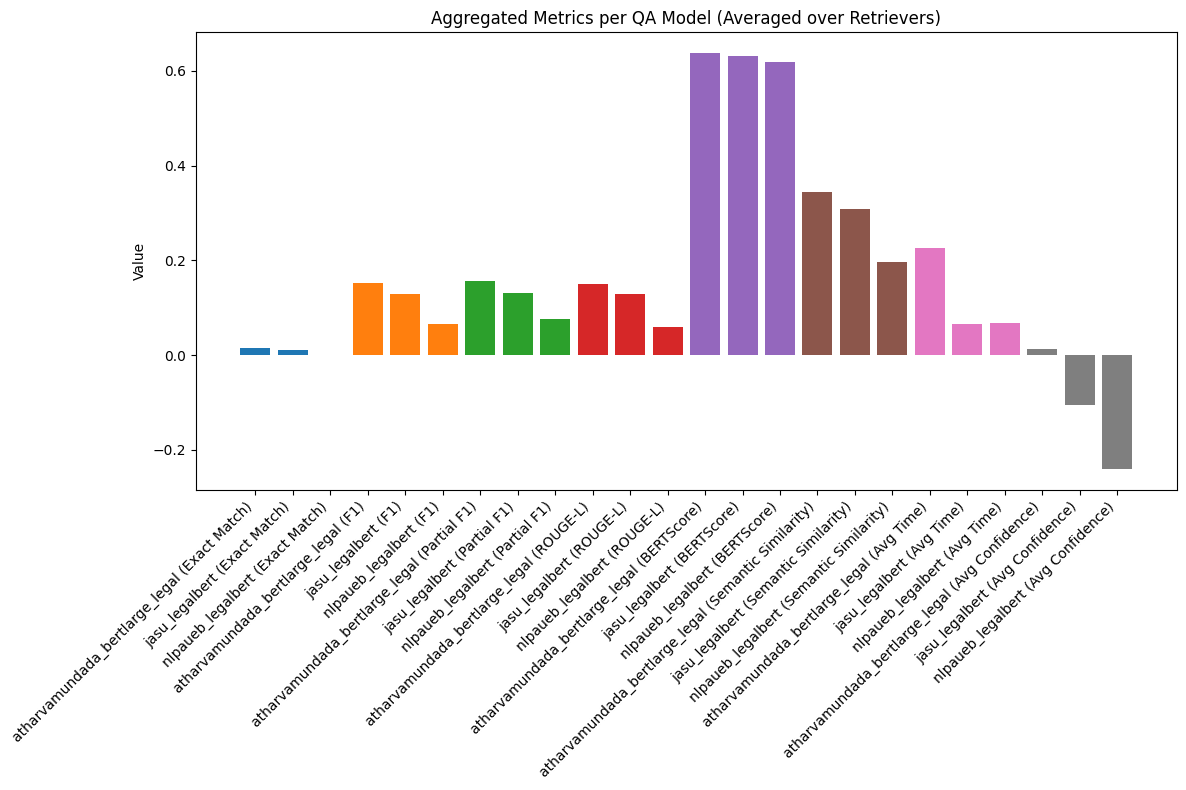

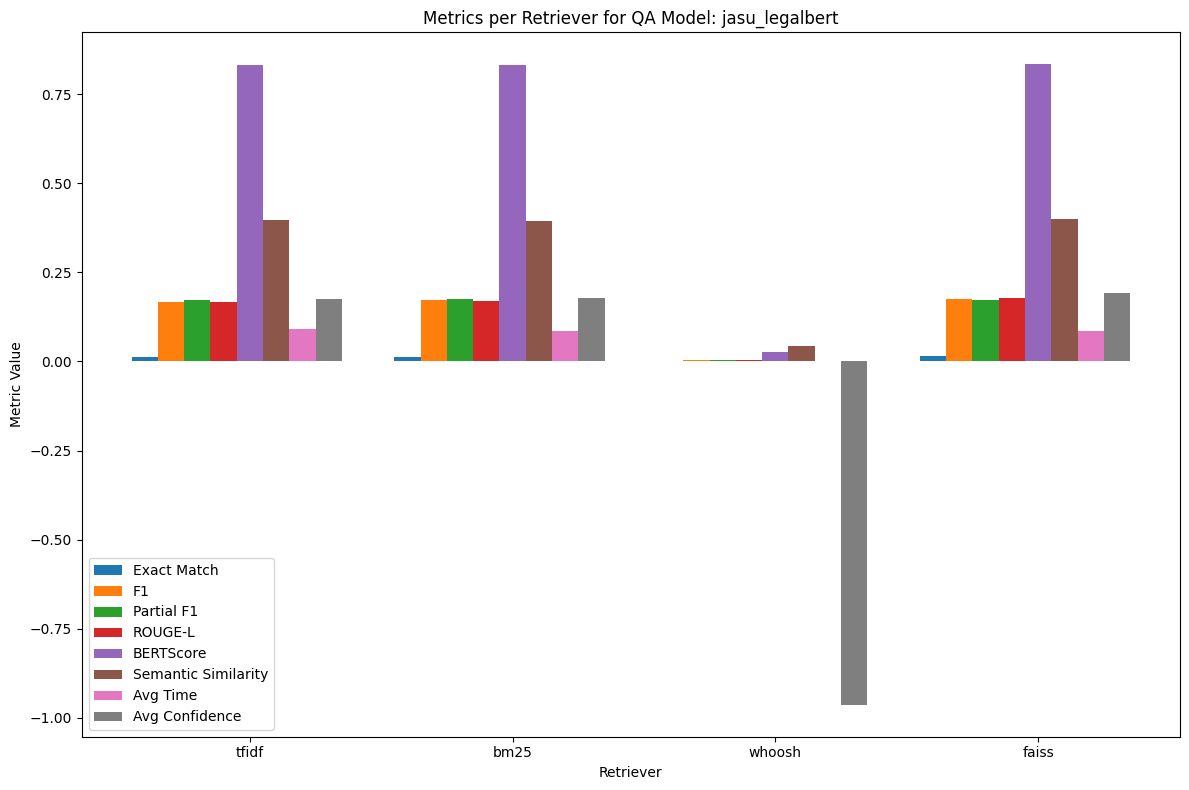

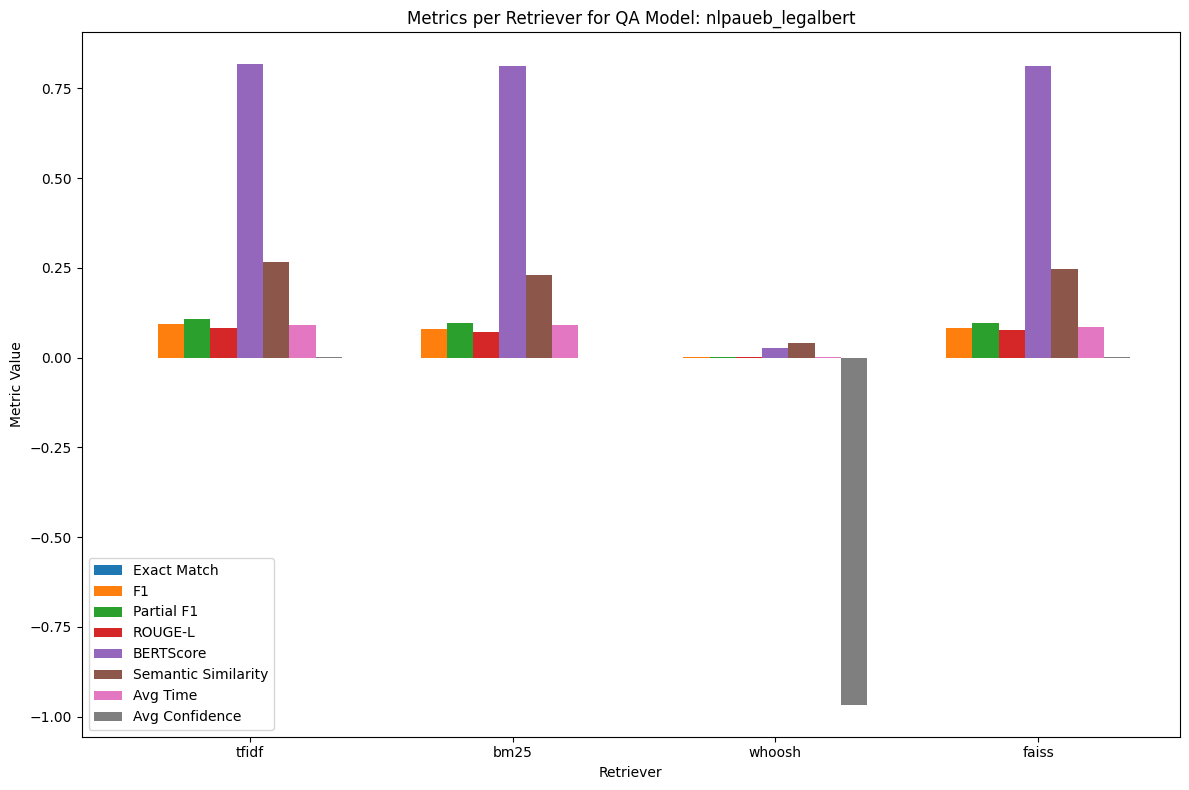

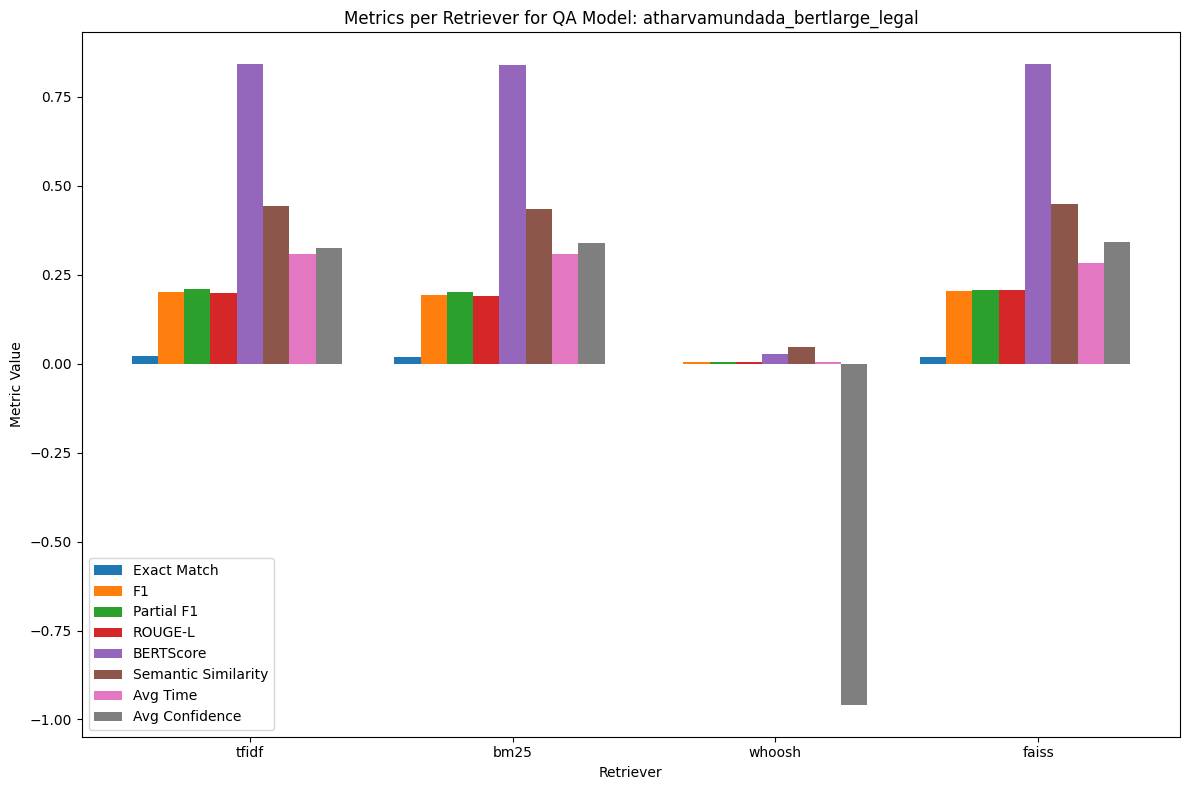

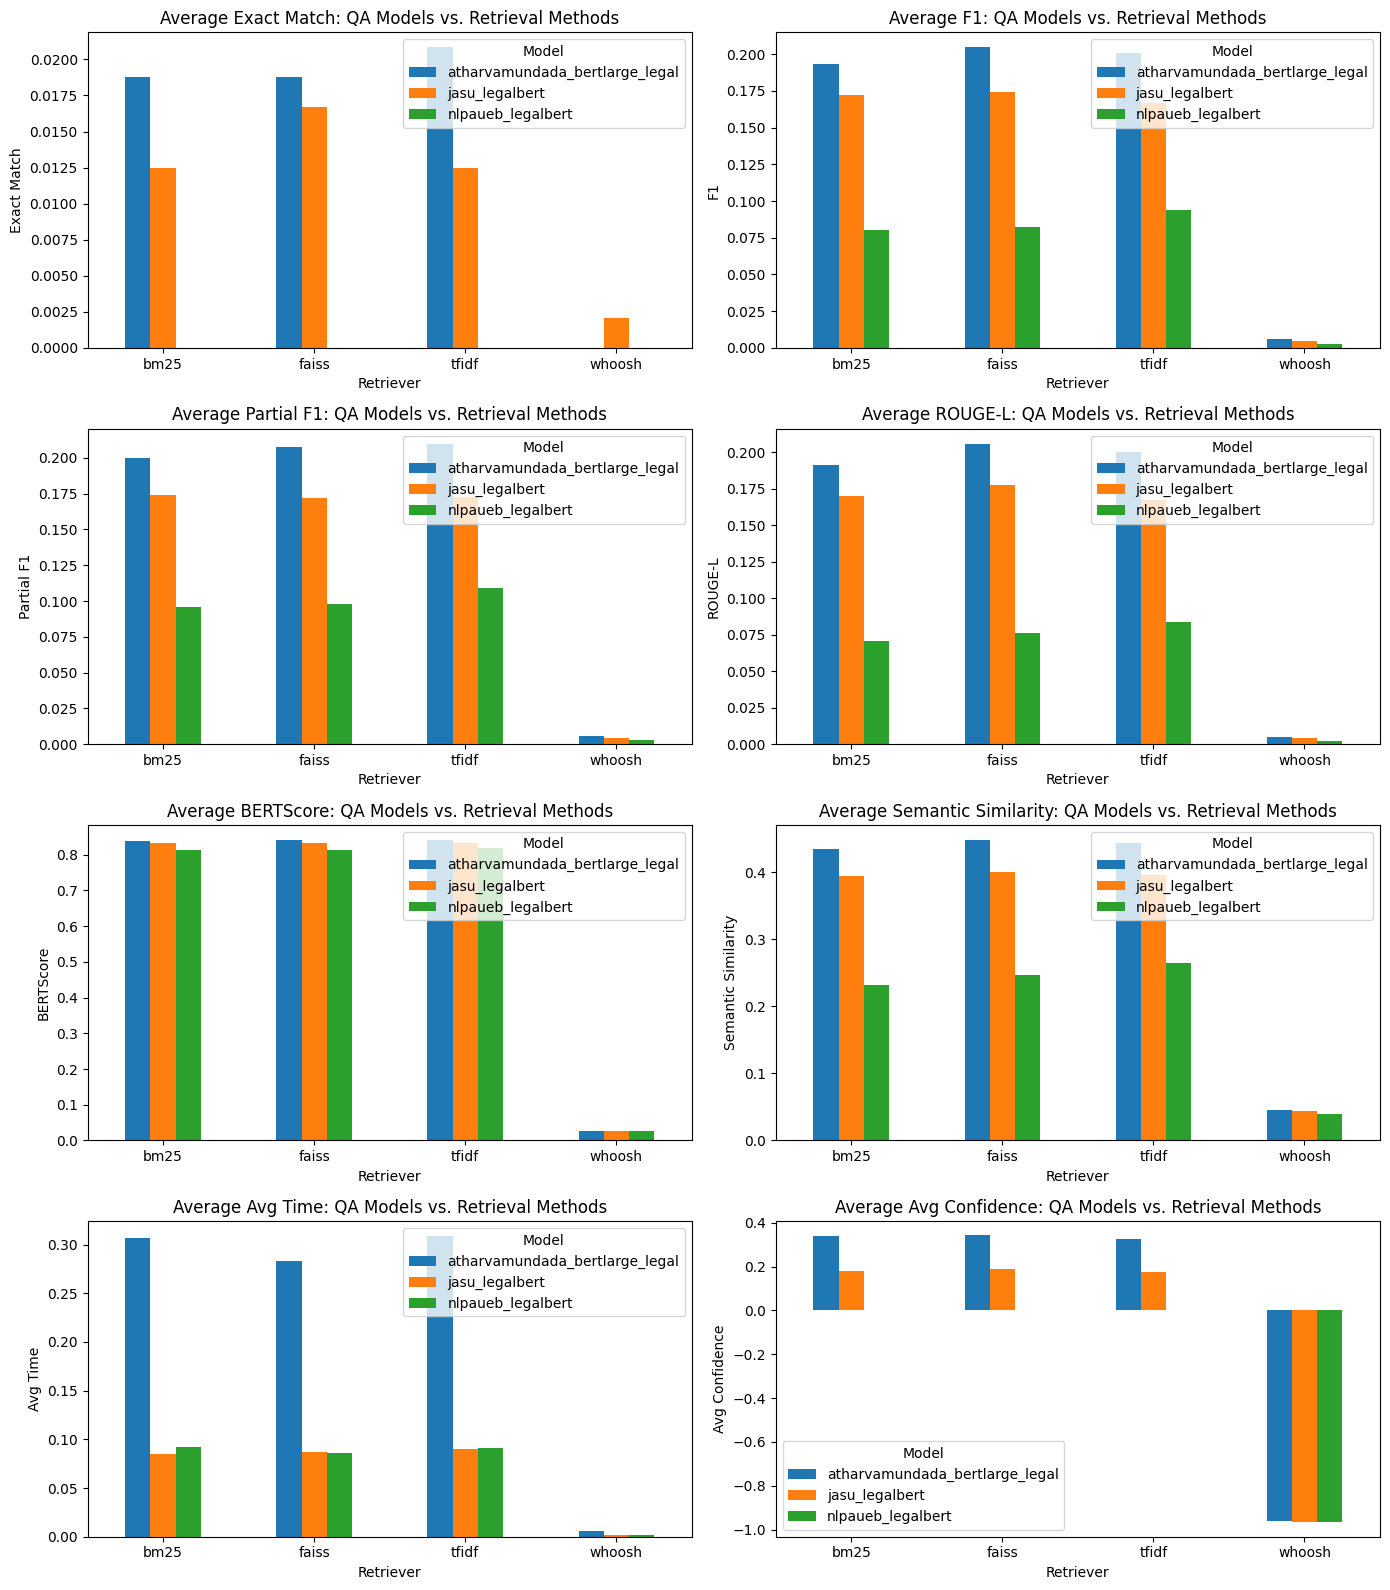

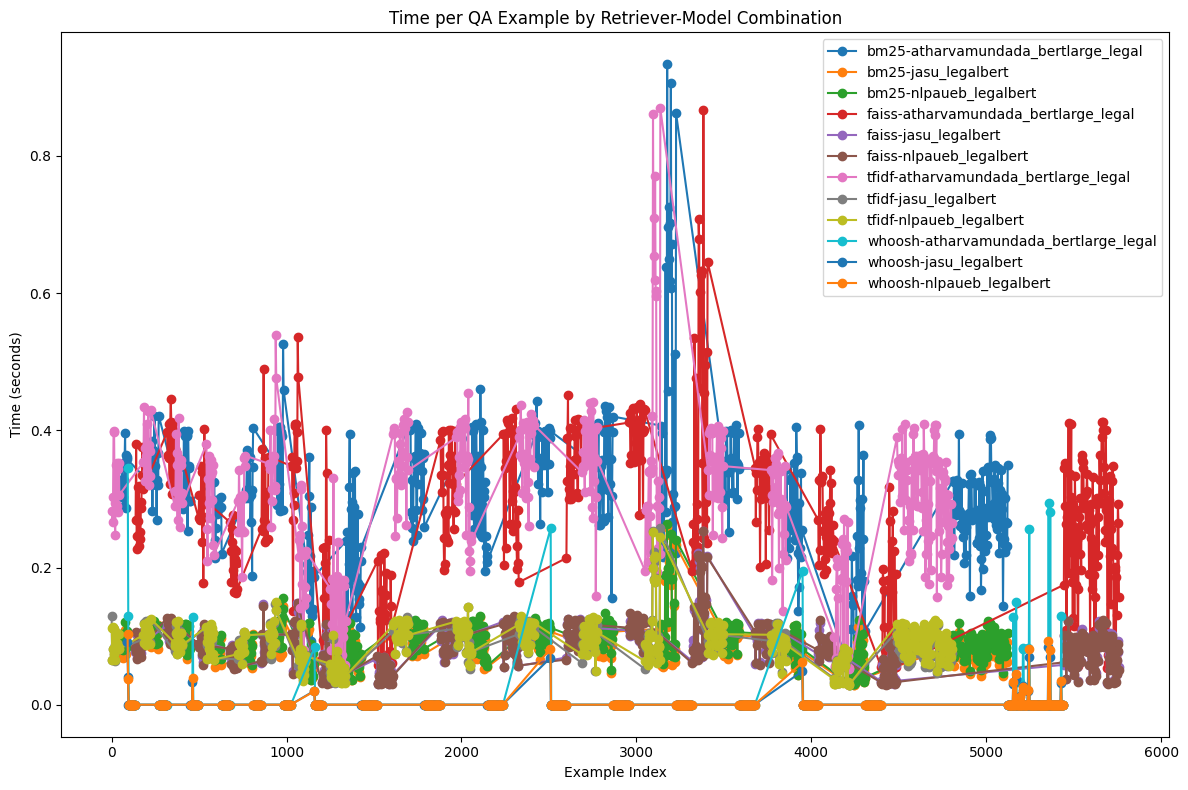

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


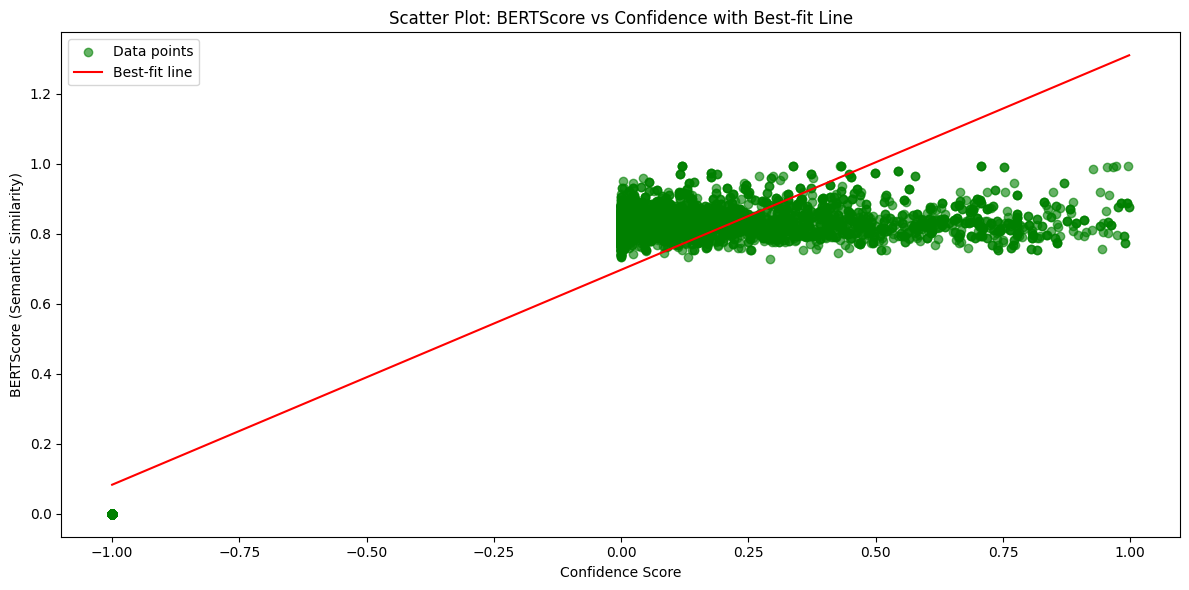

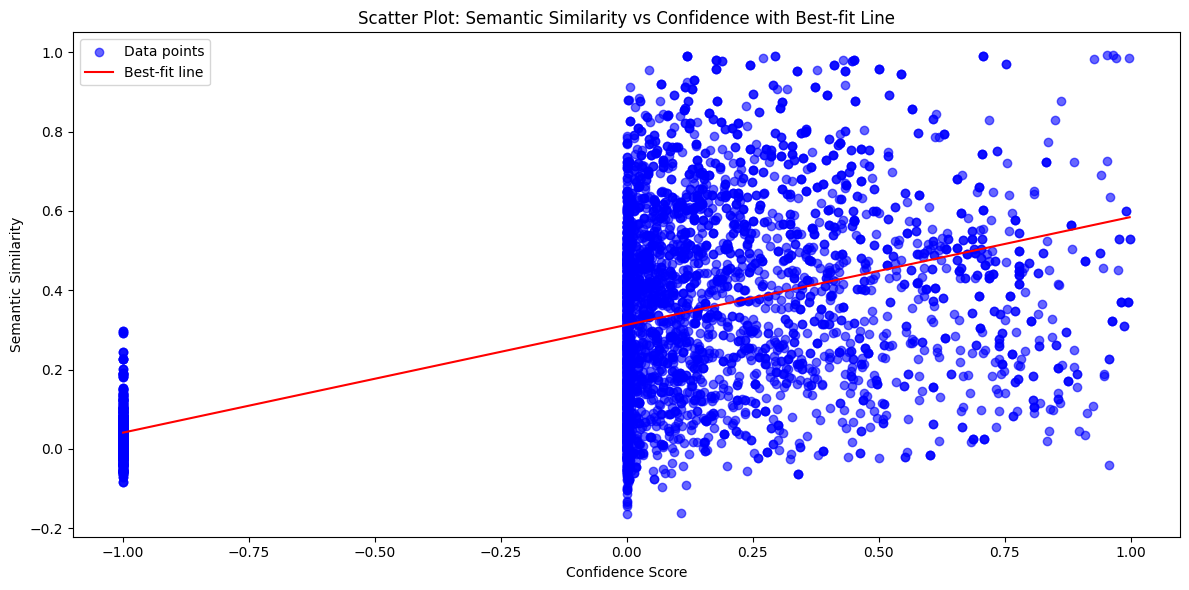

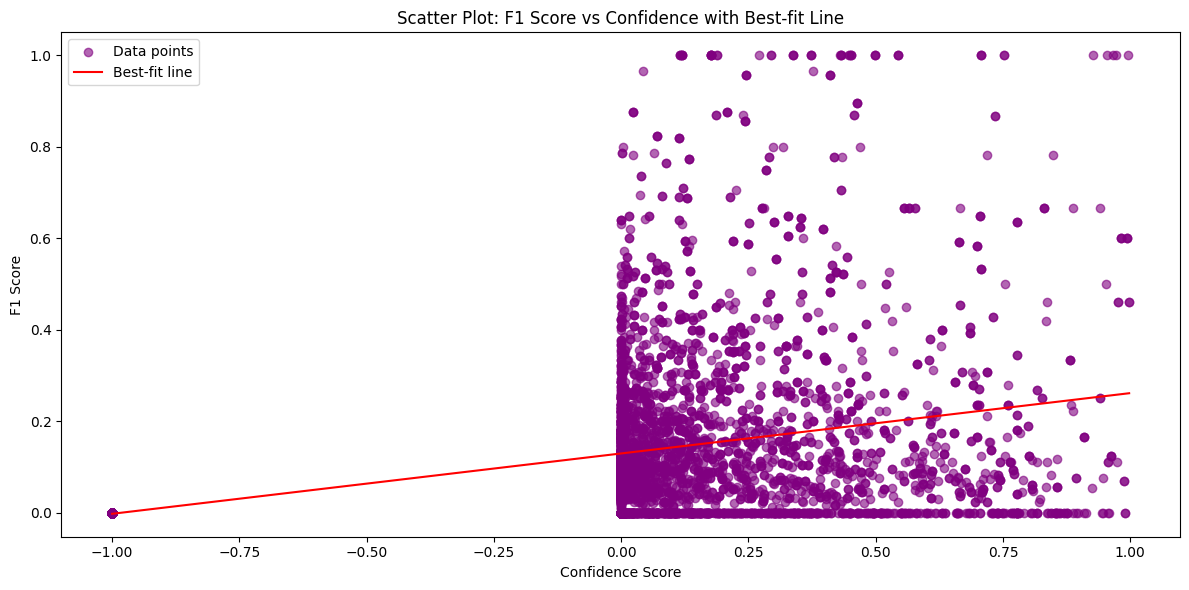

<ipython-input-42-fdf866b553e5>:286: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=combinations, patch_artist=True)


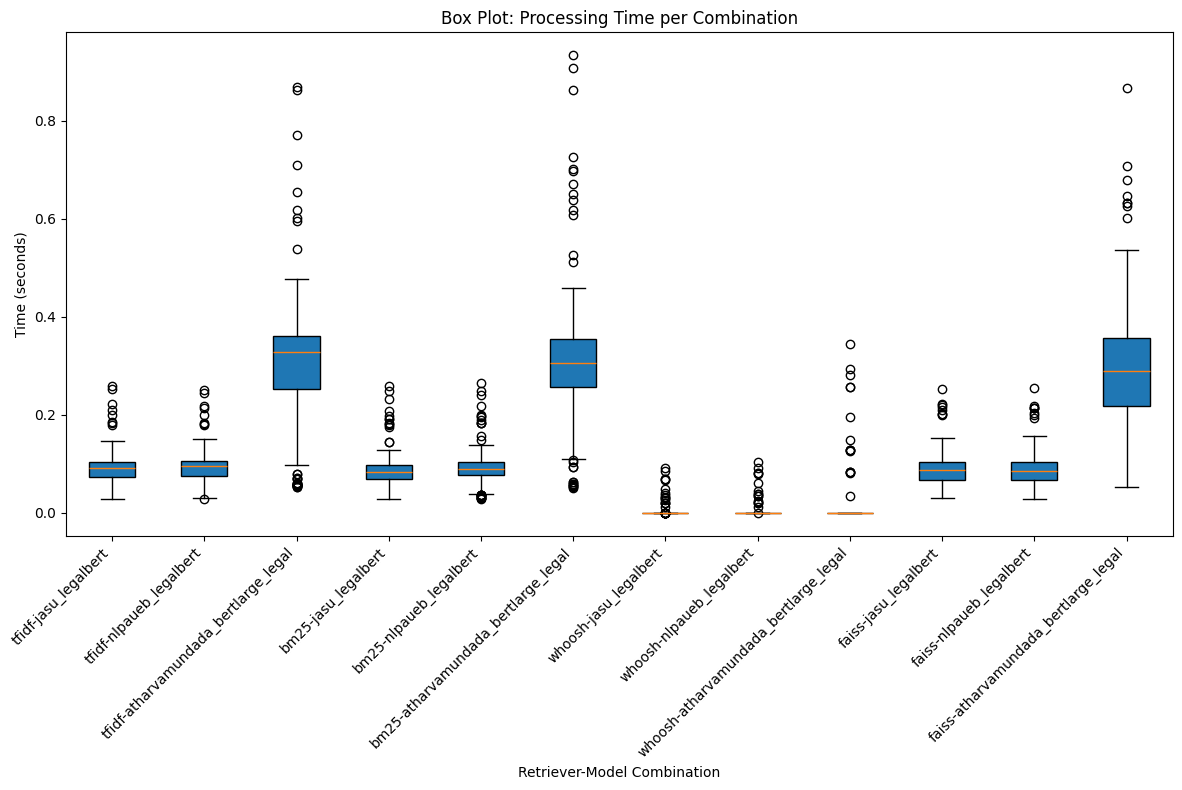

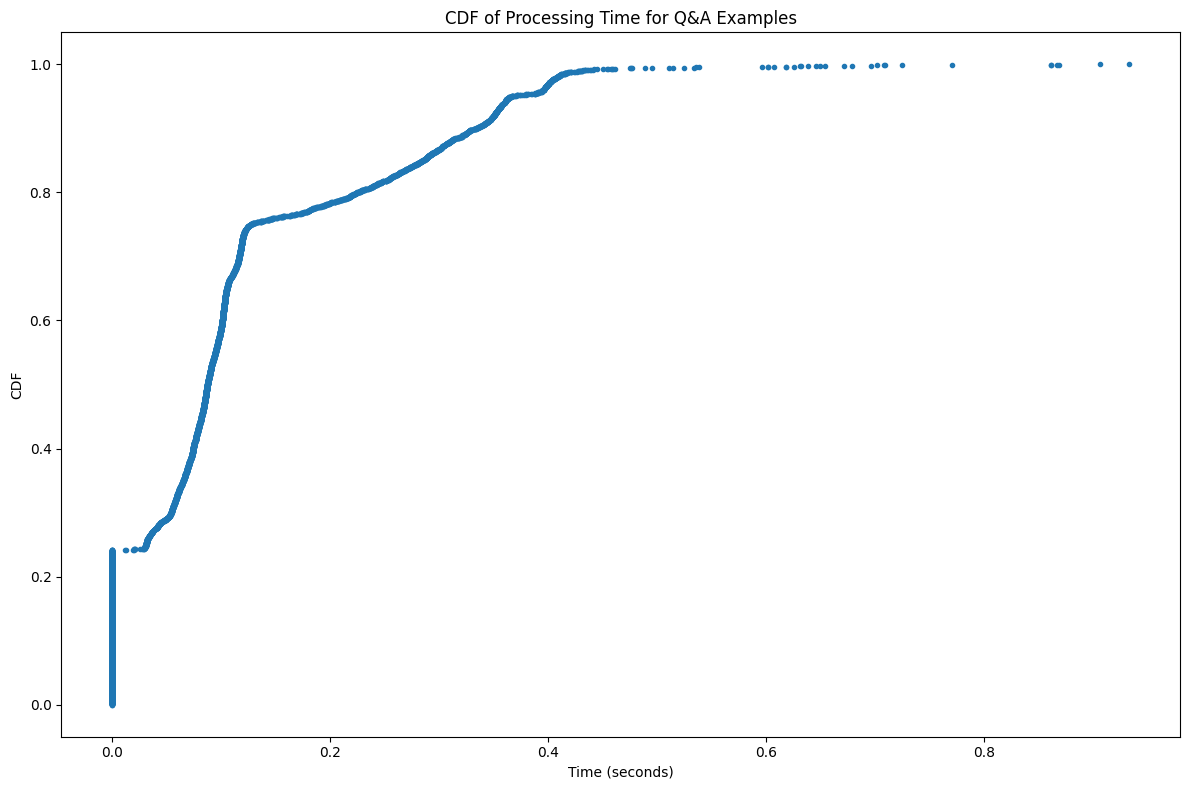

Best retriever based on combined F1, BERTScore, and Semantic Similarity: tfidf


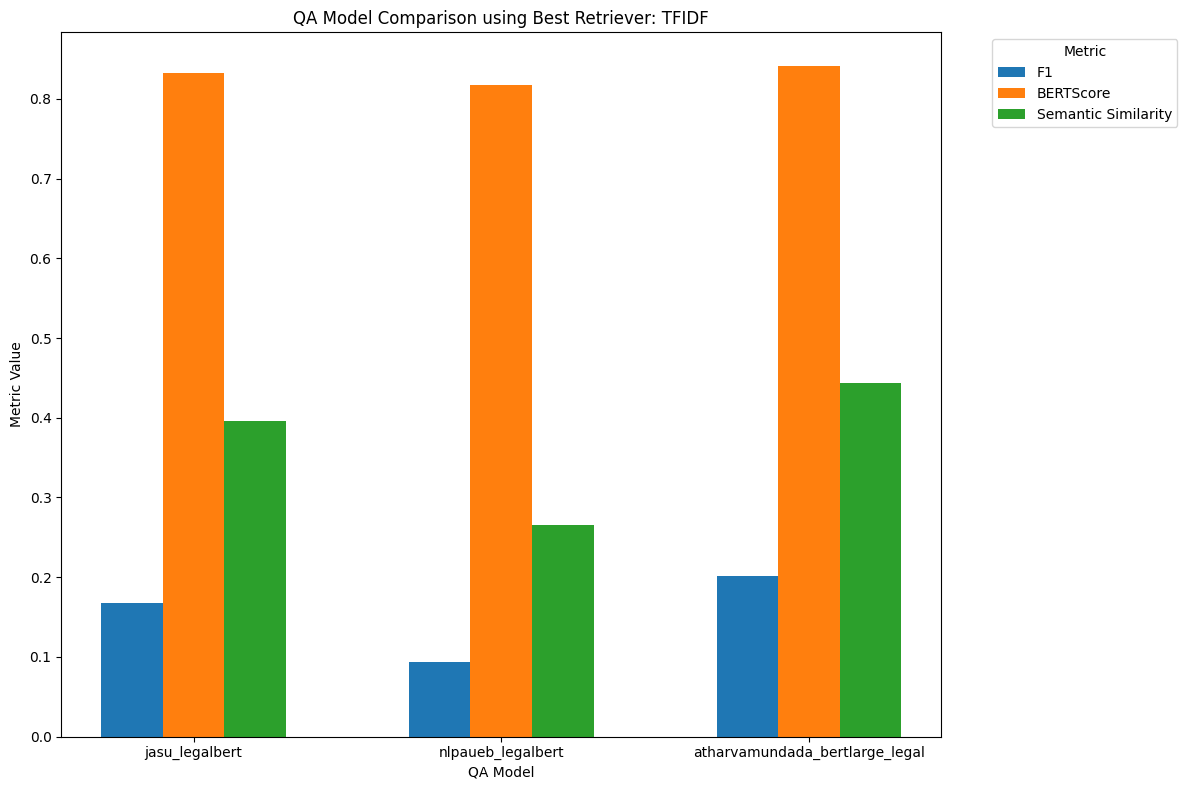

In [42]:

def main():

    # 1. Preprocess all main agreement PDFs
    process_all_agreement_pdfs()

    # 2. Build gold standard from Q&A PDFs
    build_gold_standard()




    # 3. Load gold standard Q&A
    gold_data = None
    with open(GOLD_STANDARD_JSON, "r", encoding="utf-8") as f:
        gold_data = json.load(f)

    print("Gold data keys:", list(gold_data.keys()))

    # 4. Load processed (chunked) main agreement documents
    processed_docs = {}
    for json_file in PROCESSED_DIR.glob("Agreement_*.json"):
        agreement_id = json_file.stem
        with open(json_file, "r", encoding="utf-8") as f:
            processed_docs[agreement_id] = json.load(f)

    # 5. Load QA pipelines
    qa_models = load_qa_pipelines()



    # 4) Initialize all retrievers.
    # For TF-IDF and BM25, we assume you have function-based retrievals wrapped in simple objects.
    class TfidfRetrieverWrapper:
        def index(self, chunks: List[Dict[str, str]]):
            # No persistent index is needed; this function call is a no-op.
            self.chunks = chunks
        def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
            return tfidf_search(self.chunks, query, top_k=top_k)

    class BM25RetrieverWrapper:
        def index(self, chunks: List[Dict[str, str]]):
            self.chunks = chunks
        def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
            return bm25_search(self.chunks, query, top_k=top_k)

    # Instantiate wrappers and your Whoosh and FAISS retrievers.
    tfidf_retriever = TfidfRetrieverWrapper()
    bm25_retriever = BM25RetrieverWrapper()
    whoosh_retriever = WhooshRetriever()
    faiss_retriever = FaissRetriever()

    # Build the dictionary of retrievers.
    retrievers = {
        "tfidf": tfidf_retriever,
        "bm25": bm25_retriever,
        "whoosh": whoosh_retriever,
        "faiss": faiss_retriever
    }



    # 6. Run experiments
    results = run_experiments(gold_data, processed_docs, qa_models, retrievers, top_k=3)

    # Debug: Print keys of the first result dictionary to check naming consistency.
    if results:
        print("Result keys:", results[0].keys())


        # Save detailed results to CSV.
    df_detailed = pd.DataFrame(results)
    detailed_csv_path = BASE_DIR / "detailed_results.csv"
    df_detailed.to_csv(detailed_csv_path, index=False)
    print(f"Detailed results saved to {detailed_csv_path}")

    # 7. Evaluate
    metrics = evaluate_all(results)

    # Convert aggregated metrics dictionary into a DataFrame.
    metric_rows = []
    for (retriever, model), scores in metrics.items():
        row = {"Retriever": retriever, "Model": model}
        row.update(scores)
        metric_rows.append(row)
    df_agg = pd.DataFrame(metric_rows)

    # Save aggregated metrics to CSV.
    agg_csv_path = BASE_DIR / "aggregated_metrics.csv"
    df_agg.to_csv(agg_csv_path, index=False)
    print(f"Aggregated metrics saved to {agg_csv_path}")



    print(df_agg.dtypes)
    print(df_agg.head())

    # ---------------------------
    # Chart 1: Compare QA Models (averaged over retrieval methods) for all metrics.
    # For each metric, we average over retrievers per model.

    numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
    models_avg = df_agg.groupby("Model")[numeric_cols].mean().reset_index()

    # Create a grouped bar chart where x-axis = metric, and bars = each model's average value.
    metrics_list = ["Exact Match", "F1", "Partial F1", "ROUGE-L", "BERTScore","Semantic Similarity", "Avg Time", "Avg Confidence"]

    # Reshape the data for plotting:
    df_models = pd.melt(models_avg, id_vars=["Model"], value_vars=metrics_list,
                        var_name="Metric", value_name="Value")
    fig, ax = plt.subplots(figsize=(12, 8))
    for metric in metrics_list:
        subset = df_models[df_models["Metric"] == metric]
        plt.bar(subset["Model"] + " (" + metric + ")", subset["Value"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Aggregated Metrics per QA Model (Averaged over Retrievers)")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart1.png", dpi=300)
    plt.show()

    # ---------------------------
    # Chart 2: For each QA model, plot a bar chart showing metrics per retriever.
    models = df_agg["Model"].unique()
    for model in models:
        subset = df_agg[df_agg["Model"] == model]
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(subset))  # each retrieval method for this model
        width = 0.1
        # Plot one bar per metric.
        for i, metric in enumerate(metrics_list):
            plt.bar(x + i * width, subset[metric], width, label=metric)
        plt.xticks(x + width * (len(metrics_list) / 2), subset["Retriever"])
        plt.title(f"Metrics per Retriever for QA Model: {model}")
        plt.xlabel("Retriever")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.tight_layout()
        plt.savefig(IMAGES_DIR / f"chart2_{model}.png", dpi=300)
        plt.show()

    # ---------------------------
    # Chart 3: Compare QA Models against Retrieval Methods (using average F1 as example).
    # For each retrieval method, plot a grouped bar chart of average F1 for each model.
    # Define the list of metrics you want to display.
    metrics_list = ["Exact Match", "F1", "Partial F1", "ROUGE-L", "BERTScore","Semantic Similarity", "Avg Time", "Avg Confidence"]

    # Determine the layout: here we use 2 columns.
    n_metrics = len(metrics_list)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols  # ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
    axes = axes.flatten()  # Flatten in case it's a 2D array

    for i, metric in enumerate(metrics_list):
        # Pivot the aggregated DataFrame so that rows = Retriever and columns = Model.
        pivot = df_agg.pivot(index="Retriever", columns="Model", values=metric)
        pivot.plot(kind="bar", ax=axes[i])
        axes[i].set_title(f"Average {metric}: QA Models vs. Retrieval Methods")
        axes[i].set_xlabel("Retriever")
        axes[i].set_ylabel(metric)
        axes[i].legend(title="Model")
        axes[i].set_xticklabels(pivot.index, rotation=0)

    # Remove any unused subplots.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart3.png", dpi=300)
    plt.show()


    # ---------------------------
    # Chart 4: Line graph comparing time per QA example (detailed results) by retriever-model combination.
    fig, ax = plt.subplots(figsize=(12, 8))
    for (retriever, model), subset in df_detailed.groupby(["retriever", "Model"]):
        label = f"{retriever}-{model}"
        plt.plot(subset.index, subset["time"], marker="o", label=label)
    plt.title("Time per QA Example by Retriever-Model Combination")
    plt.xlabel("Example Index")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart4.png", dpi=300)
    plt.show()




    # Compute instance-level F1 for each row.
    def compute_f1_for_row(row):
        return compute_token_level_f1(row["pred_answer"], row["gold_answer"])

    df_detailed['F1'] = df_detailed.apply(compute_f1_for_row, axis=1)

    # Compute instance-level semantic similarity using BERTScore.
    # We compute BERTScore for all predictions against gold answers.
    from bert_score import score as bertscore_score
    P, R, F = bertscore_score(df_detailed['pred_answer'].tolist(),
                            df_detailed['gold_answer'].tolist(),
                            lang="en")
    df_detailed['BERTScore'] = F.tolist()



    # Initialize the embedder (you might want to do this once outside the lambda if performance is an issue)
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

    def compute_semantic_similarity(pred, gold):
        # Get embeddings for the prediction and gold answer
        pred_emb = embedder.encode([pred])
        gold_emb = embedder.encode([gold])
        # Compute and return cosine similarity
        return float(cosine_similarity(pred_emb, gold_emb)[0][0])

    # Compute semantic similarity for each row in df_detailed and add as a new column
    df_detailed['Semantic Similarity'] = df_detailed.apply(lambda row: compute_semantic_similarity(row['pred_answer'], row['gold_answer']), axis=1)



    # Example: Scatter Plot for BERTScore vs Confidence with Best-fit Line.
    x = df_detailed['confidence'].values
    y = df_detailed['BERTScore'].values
    coeffs = np.polyfit(x, y, 1)  # Linear fit coefficients.
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = np.polyval(coeffs, line_x)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.6, color='green', label="Data points")
    plt.plot(line_x, line_y, color='red', label="Best-fit line")
    plt.xlabel("Confidence Score")
    plt.ylabel("BERTScore (Semantic Similarity)")
    plt.title("Scatter Plot: BERTScore vs Confidence with Best-fit Line")
    plt.legend()
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "scatter_bert_sem_sim_conf.png", dpi=300)
    plt.show()

    # Scatter Plot for Semantic Similarity vs Confidence with Best-fit Line.
    x = df_detailed['confidence'].values
    y = df_detailed['Semantic Similarity'].values
    coeffs = np.polyfit(x, y, 1)
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = np.polyval(coeffs, line_x)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.6, color='blue', label="Data points")
    plt.plot(line_x, line_y, color='red', label="Best-fit line")
    plt.xlabel("Confidence Score")
    plt.ylabel("Semantic Similarity")
    plt.title("Scatter Plot: Semantic Similarity vs Confidence with Best-fit Line")
    plt.legend()
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "scatter_sem_sim_conf.png", dpi=300)
    plt.show()

    # Scatter Plot for F1 Score vs Confidence with Best-fit Line.
    x = df_detailed['confidence'].values
    y = df_detailed['F1'].values
    coeffs = np.polyfit(x, y, 1)
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = np.polyval(coeffs, line_x)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.6, color='purple', label="Data points")
    plt.plot(line_x, line_y, color='red', label="Best-fit line")
    plt.xlabel("Confidence Score")
    plt.ylabel("F1 Score")
    plt.title("Scatter Plot: F1 Score vs Confidence with Best-fit Line")
    plt.legend()
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "scatter_f1_conf.png", dpi=300)
    plt.show()


    # ---------------------------
    # Box Plot: Processing Time by Retriever-Model Combination

    # Create a new column combining retriever and model.
    df_detailed['Combination'] = df_detailed['retriever'] + "-" + df_detailed['Model']
    combinations = df_detailed['Combination'].unique()
    data = [df_detailed[df_detailed['Combination'] == comb]['time'].values for comb in combinations]

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.boxplot(data, labels=combinations, patch_artist=True)
    plt.xlabel("Retriever-Model Combination")
    plt.ylabel("Time (seconds)")
    plt.title("Box Plot: Processing Time per Combination")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "boxplot_time.png", dpi=300)
    plt.show()

    # ---------------------------
    # CDF Plot: Cumulative Distribution of Processing Time
    sorted_time = np.sort(df_detailed['time'].values)
    cdf = np.arange(len(sorted_time)) / float(len(sorted_time))
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.plot(sorted_time, cdf, marker=".", linestyle="none")
    plt.xlabel("Time (seconds)")
    plt.ylabel("CDF")
    plt.title("CDF of Processing Time for Q&A Examples")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "cdf_time.png", dpi=300)
    plt.show()

    #----FINALLY BEST RETREVIVER MODEL COMPARISON


    # First, group the aggregated DataFrame by Retriever and compute the mean for each metric.
    # df_agg is assumed to have columns: "Retriever", "Model", "F1", "BERTScore", "Semantic Similarity", etc.
    metrics_for_selection = ["F1", "BERTScore", "Semantic Similarity"]
    grouped_retrievers = df_agg.groupby("Retriever")[metrics_for_selection].mean()

    # Select only the metrics we want to use for selecting the best retriever.
    metrics_for_selection = ["F1", "BERTScore", "Semantic Similarity"]

    # Compute a combined score for each retriever (here, a simple average).
    grouped_retrievers["Combined"] = grouped_retrievers[metrics_for_selection].mean(axis=1)

    # Choose the retriever with the highest combined score.
    best_retriever = grouped_retrievers["Combined"].idxmax()
    print(f"Best retriever based on combined F1, BERTScore, and Semantic Similarity: {best_retriever}")

    # --- Filter the aggregated DataFrame for the best retriever and compare models ---
    df_best = df_agg[df_agg["Retriever"] == best_retriever]

    # Define the list of metrics to compare (F1, BERTScore, and Semantic Similarity)
    metrics_list = ["F1", "BERTScore", "Semantic Similarity"]

    # Get the list of QA models for this retriever
    models = df_best["Model"].unique()
    n_models = len(models)
    bar_width = 0.2
    x = np.arange(n_models)

    fig, ax = plt.subplots(figsize=(12, 8))

    # For each metric, plot bars for each model.
    for i, metric in enumerate(metrics_list):
        values = []
        for model in models:
            value = df_best[df_best["Model"] == model][metric].values
            if len(value) == 0:
                values.append(0)
            else:
                values.append(value[0])
        ax.bar(x + i * bar_width, values, bar_width, label=metric)

    # Set x-ticks in the center of each group.
    ax.set_xticks(x + bar_width * (len(metrics_list) - 1) / 2)
    ax.set_xticklabels(models)
    ax.set_title(f"QA Model Comparison using Best Retriever: {best_retriever.upper()}")
    ax.set_xlabel("QA Model")
    ax.set_ylabel("Metric Value")
    ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "best_retriever_model_comparison.png", dpi=300)
    plt.show()


    # Cleanup for Whoosh (delete temporary index)
    whoosh_retriever.cleanup()

if __name__ == "__main__":
    main()

# Download all files